<a href="https://colab.research.google.com/github/santimndez/tfm/blob/main/src/notebooks/track_ball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video.

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = True
import os

In [2]:
!pwd

/content


In [3]:
if using_colab and not os.path.isdir('../sam2'):
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    # Modelo SAM2 tiny
    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt

    !pip install decord

PyTorch version: 2.5.1+cpu
Torchvision version: 0.20.1+cpu
CUDA is available: False
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-hidoeb7e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-hidoeb7e
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.4 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-py3-none-any

In [4]:
# Vídeo de prueba
FILE_ID = "1VqoB9a6qVoX5utNEEgV0wdnp-rQnz1Qi"

if not os.path.isdir('./videos'):
  !mkdir videos
  !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=$FILE_ID" -O videos/test.mp4

--2025-02-07 21:52:55--  https://drive.google.com/uc?export=download&id=1VqoB9a6qVoX5utNEEgV0wdnp-rQnz1Qi
Resolving drive.google.com (drive.google.com)... 209.85.200.102, 209.85.200.139, 209.85.200.113, ...
Connecting to drive.google.com (drive.google.com)|209.85.200.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1VqoB9a6qVoX5utNEEgV0wdnp-rQnz1Qi&export=download [following]
--2025-02-07 21:52:55--  https://drive.usercontent.google.com/download?id=1VqoB9a6qVoX5utNEEgV0wdnp-rQnz1Qi&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.184.132, 2607:f8b0:4001:c66::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.184.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5118084 (4.9M) [video/mp4]
Saving to: ‘videos/test.mp4’

videos/test.mp4     100%[===================>]   4.88M  29.3MB/s    in 0.2s 

## Set-up

In [5]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


### Loading the SAM 2 video predictor

In [7]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [8]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

#def add_mask(frame, mask, obj_id=None, random_color=False):
#    if random_color:
#        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#    else:
#        cmap = plt.get_cmap("tab10")
#        cmap_idx = 0 if obj_id is None else obj_id
#        color = np.array([*cmap(cmap_idx)[:3], 0.6])
#    h, w = mask.shape[-2:]
#
#    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [9]:
video_path = './videos/test.mp4'
inference_state = predictor.init_state(video_path=video_path)

### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [10]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

In [11]:
ann_frame_idx = 113  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[937, 418], [936, 410], [906, 423], [961, 404]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1, 0, 0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

/usr/local/lib/python3.11/dist-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/usr/local/lib/python3.11/dist-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


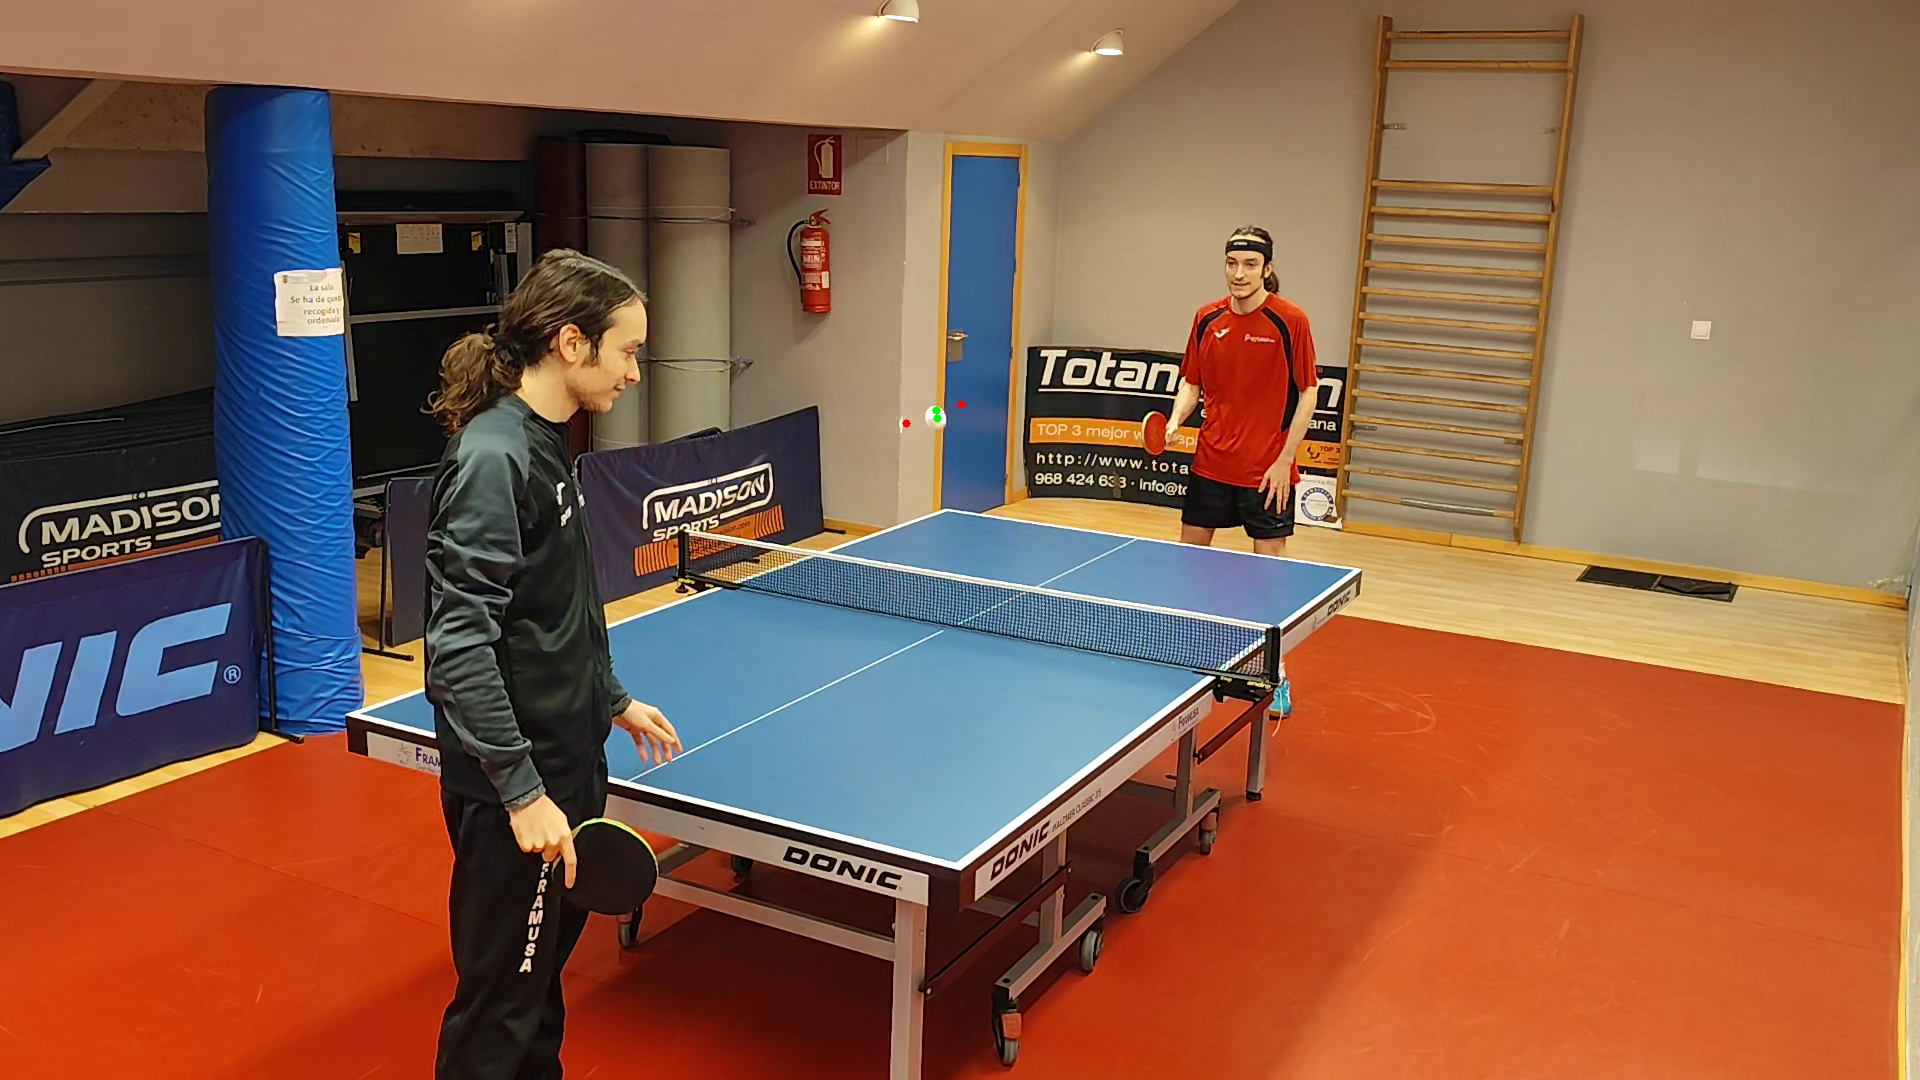

In [12]:
import cv2
from google.colab.patches import cv2_imshow
def extract_frame(video, framepos):
  videoreader = cv2.VideoCapture(video)

  while True:
    (grabbed, frame) = videoreader.read()
    if not grabbed:
      break
    if framepos == 0:
      break
    framepos -= 1
  videoreader.release()
  return frame

frame = extract_frame(video_path, ann_frame_idx)
for row in range(points.shape[0]):
  cv2.circle(frame, (int(points[row, 0]), int(points[row, 1])), 4, (0, 255, 0) if labels[row] else (0, 0, 255), -4)
cv2_imshow(frame)

#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [13]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# show a video
# vis_frame_stride = 30
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 345/345 [1:03:51<00:00, 11.11s/it]


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Video
from io import BytesIO
from IPython.display import HTML

# Función para mostrar un video con las máscaras de las pelotas
def show_video_with_masks(video_segments, video_path):
    cap = cv2.VideoCapture(video_path)  # Cargar el video
    frames = []  # Lista para almacenar los cuadros procesados
    printbool = True
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Obtener el número de cuadro (frame index)
        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        if frame_idx not in video_segments:
            continue

        # Obtener las máscaras para este cuadro
        frame_mask = np.zeros_like(frame)
        for obj_id, mask in video_segments[frame_idx].items():
            frame_mask[mask[0, :], :] = [0, 255, 0]  # Colorear la pelota en verde

        if printbool:
          print(frame.shape)
          print(mask.shape)
          printbool = False

        # Superponer la máscara sobre el cuadro original
        frame_with_mask = cv2.addWeighted(frame, 0.7, frame_mask, 0.3, 0)

        # Añadir el cuadro procesado a la lista
        frames.append(frame_with_mask)

    cap.release()

    # Convertir los cuadros procesados en un archivo de video para mostrar
    video_output_path = "./output_video.mp4"
    height, width, layers = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_output_path, fourcc, 30.0, (width, height))

    for frame in frames:
        out.write(frame)
    out.release()

    # Mostrar el video resultante
    return video_output_path

# Ruta al video original
video_path = 'videos/test.mp4'

# Llamar a la función para mostrar el video con las máscaras de la pelota
video_output_path = show_video_with_masks(video_segments, video_path)

(1080, 1920, 3)
(1, 1080, 1920)


In [30]:
# El vídeo no se muestra en colab por ser muy pesado
# Se puede descargar el vídeo de output_video.mp4
from IPython.display import HTML

video_path = "/content/output_video.mp4"
HTML(f"""<video width="600" controls>
            <source src="{video_path}" type="video/mp4">
         </video>""")